<a href="https://colab.research.google.com/github/PedroFlorencioNeto/visgeo/blob/main/01_InfraestruturaCicloviaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1W7wp7qdhvQPokxmaFfSMwftfHOs55JR3)


---
<center><h3></h3>
<h3><b>Visualização e Processamento de Dados Geoespaciais: Acessibilidade a Malha Cicloviária<br><h4><b>Python Nordeste 2024</b></h4></b></h3></center>


<br>Este notebook tem como objetivo apresentar de forma prática os principais métodos e conceitos sobre geoprocessamento de dados e visualização de mapas aos participantes do Python Nordeste 2024.

**Autor:** Pedro Florencio de Almeida Neto - Cientista de Dados @Ipplan
| @BioData (UFC)

**Contato:** <i>pedroflorencio@alu.ufc.br</i>

---

**Objetivo:** Calcular e visualizar o indicador PNB nos bairros de Natal-RN.

#### **1. Contextualização**

O indicador *People Near Bike Lanes* (PNB), desenvolvido pelo *Institute for Transportation and Development Policy* (ITDP), foi criado para medir a acessibilidade das infraestruturas de ciclovias e a proximidade da população a essas vias, com o objetivo de promover políticas públicas e planejamentos urbanos que incentivem o uso da bicicleta como um meio de transporte sustentável, acessível e seguro.

Neste tutorial, você aprenderá a calcular e visualizar o comportamento do indicador no seu município, permitindo assim monitorar a acessibilidade à infraestrutura em todos os bairros.

#### **2. Metodologia**

O **PNB** é definido matematicamente como a **proporção da população que vive a pelo menos 300 metros de uma infraestrutura cicloviária**, sendo um valor de varia de 0 a 1, isto é, de 0 a 100% da população.

$PNB = \frac{populacao_{proxima}}{populacao_{total}}$ [1]

Sendo:

- **populacao_proxima**: Número de pessoas em que suas habitações estão contidas em um raio de até 300 metros de infraestrutura cicloviária.
- **populacao_total**: Número total de pessoas no espaço avaliado, podendo ser bairro, município, subdistrito, entre outros.

Para **estimativa da população contida no raio de 300 metros**, utiliza-se como unidade territorial os microdados de **setores censitários** disponibilizados pelo IBGE, que correspondem a menor porção em que o território é fragmentado no Brasil e que se é possível determinar o número de habitantes. Como a infraestrutura cicloviária e seu raio podem dividir um setor censitário, é considerada uma premissa como aproximação: de que a população é distribuída de maneira uniforme em todo o espaço do setor censitário em avaliação, sendo calculada a relação de área para determinação da população dos polígonos divididos.

A **Malha Preliminar de Setores Censitários** foram adquiridas através do site do [IBGE](https://www.ibge.gov.br/estatisticas/sociais/populacao/22827-censo-demografico-2022.html?edicao=39499&t=resultados), em tabelas divulgadas no dia 21/03/2024.

> **Fontes dos dados:**
- Limites dos bairros de Natal | [Address For All](https://www.addressforall.org/en/downloads/#Brazil)
- Infraestrutura cicloviária de Natal | [Google My Maps](https://www.google.com/maps/d/u/0/viewer?mid=1x474AeGEWUAAcvDTgS_fxg-J0Hg&femb=1&ll=-5.840903345747478%2C-35.22957610949073&z=12)
- População dos setores censitários | [IBGE](https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios_preliminares/agregados_por_setores_csv/UF/#:~:text=14M-,Agregados_preliminar..%3E,-2024%2D03%2D20)
- Malha de setores censitários | [IBGE](https://www.ibge.gov.br/geociencias/downloads-geociencias.html?caminho=organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2022_preliminar/setores/gpkg/UF)

#### **3. Bibliotecas**

In [ ]:
!pip install -q mapclassify
!pip3 install -q contextily

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as cx
import plotly.express as px
from google.colab import drive
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors

drive.mount('/gdrive', force_remount=True)

%matplotlib inline

Mounted at /gdrive


#### **4. Aquisição dos Dados**

**Instruções:**

1. Solicitar acesso à pasta **[PyNE](https://drive.google.com/drive/folders/1Ac-fpV8r78gc6IKm8JfORZNNZJegiKSt?usp=drive_link)**;
2. Clicar com o botão direito e criar um **atalho** para Meu Drive | *My Drive*.

In [ ]:
# caminho para os dados brutos
caminho_dados = '/gdrive/MyDrive/PyNE/dados_brutos/'

# setores censitarios do Rio Grande do Norte
df_setores = pd.read_csv(caminho_dados+'agregados_preliminares_por_setores_censitarios_RN.csv', sep=';')

# malha georreferenciada de setores censitarios
gdf_setores = gpd.read_file(caminho_dados+'RN_malha_preliminar_2022.gpkg', crs='EPSG:4326', driver='GPKG')

# limites dos bairros de Natal
gdf_bairros = gpd.read_file(caminho_dados+'bairros_natal/bairros.shp', crs='EPSG:4326')

# infraestrutura cicloviaria


**Objetos de interesse:**

- `gdf_bairros`: GeoDataframe dos bairros de Natal.
- `df_setores`: DataFrame dos setores censitarios do Rio Grande do Norte.
- `gdf_setores`: GeoDataFrame da malha de setores censitarios do Rio Grande do Norte.
- `gdf_infraestrutura`: GeoDataFrame do mapa cicloviaria de Natal.




#### **5. Entendimento dos Dados**

##### **5.1. Setores Censitários**

In [ ]:
df_setores.head()

CD_SETOR  AREA_KM2  CD_REGIAO NM_REGIAO  CD_UF  \
0  240010905000001P  0.342964          2  Nordeste     24   
1  240010905000002P  0.707408          2  Nordeste     24   
2  240010905000003P  0.062812          2  Nordeste     24   
3  240010905000004P  0.176762          2  Nordeste     24   
4  240010905000005P  0.226327          2  Nordeste     24   

                 NM_UF   CD_MUN NM_MUN    CD_DIST NM_DIST  ...  NM_RGINT  \
0  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
1  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
2  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
3  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   
4  Rio Grande do Norte  2400109  Acari  240010905   Acari  ...     Caicó   

  CD_CONCURB  NM_CONCURB v0001  v0002 v0003  v0004     v0005     v0006 v0007  
0        NaN         NaN   246    117   117      0  2.733333  4.444444    90  
1        NaN         NaN   728    300   300      0  2.854902  0.784314   255  
2        NaN         NaN   665    276   276      0  2.736626  0.823045   243  
3        NaN         NaN   309    118   118      0  2.942857  0.952381   105  
4        NaN         NaN   554    225   224      1  2.826531  0.000000   196  

[5 rows x 29 columns]

In [ ]:
df_setores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5975 entries, 0 to 5974
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CD_SETOR    5975 non-null   object 
 1   AREA_KM2    5975 non-null   float64
 2   CD_REGIAO   5975 non-null   int64  
 3   NM_REGIAO   5975 non-null   object 
 4   CD_UF       5975 non-null   int64  
 5   NM_UF       5975 non-null   object 
 6   CD_MUN      5975 non-null   int64  
 7   NM_MUN      5975 non-null   object 
 8   CD_DIST     5975 non-null   int64  
 9   NM_DIST     5975 non-null   object 
 10  CD_SUBDIST  5975 non-null   int64  
 11  NM_SUBDIST  5975 non-null   object 
 12  CD_MICRO    5975 non-null   int64  
 13  NM_MICRO    5975 non-null   object 
 14  CD_MESO     5975 non-null   int64  
 15  NM_MESO     5975 non-null   object 
 16  CD_RGI      5975 non-null   int64  
 17  NM_RGI      5975 non-null   object 
 18  CD_RGINT    5975 non-null   int64  
 19  NM_RGINT    5975 non-null  

**Dicionário de Dados - Setores Censitários**

| Variável        | Tipo      | Tamanho | Descrição                                                             |
|-----------------|-----------|---------|-----------------------------------------------------------------------|
| CD_SETOR        | texto     | 16      | Geocódigo de Setor Censitário                                        |
| AREA_KM2        | real      |         | Área do Setor Censitário em quilômetros quadrados                    |
| CD_REGIAO       | numérico  | 1       | Código das Grandes Regiões (Regiões Geográficas)                      |
| NM_REGIAO       | texto     | 15      | Nome das Grandes Regiões (Regiões Geográficas)                        |
| CD_UF           | numérico  | 2       | Código da Unidade da Federação                                        |
| NM_UF           | texto     | 20      | Nome da Unidade da Federação                                          |
| CD_MUN          | numérico  | 7       | Código do município                                                   |
| NM_MUN          | texto     | 50      | Nome do município                                                     |
| CD_DIST         | numérico  | 9       | Código do distrito                                                    |
| NM_DIST         | texto     | 50      | Nome do distrito                                                      |
| CD_SUBDIS       | numérico  | 11      | Código do subdistrito                                                  |
| NM_SUBDIST      | texto     | 50      | Nome do subdistrito                                                    |
| CD_MICRO        | numérico  | 5       | Código da microrregião                                                 |
| NM_MICRO        | texto     | 50      | Nome da microrregião                                                   |
| CD_MESO         | numérico  | 4       | Código da mesorregião                                                  |
| NM_MESO         | texto     | 50      | Nome da mesorregião                                                    |
| CD_RGI          | numérico  | 6       | Código da região geográfica imediata                                   |
| NM_RGI          | texto     | 50      | Nome da região geográfica imediata                                     |
| CD_RGINT        | numérico  | 4       | Código da região geográfica intermediária                             |
| NM_RGINT        | texto     | 50      | Nome da região geográfica intermediária                               |
| CD_CONCURB      | numérico  | 7       | Código da Concentração Urbana                                          |
| NM_CONCURB      | texto     | 50      | Nome da Concentração Urbana                                            |
| V0001           | numérico  |         | Total de pessoas                                                       |
| V0002           | numérico  |         | Total de Domicílios (DPPO + DPPV + DPPUO + DPIO + DCCM + DCSM)        |
| V0003           | numérico  |         | Total de Domicílios Particulares (DPPO + DPPV + DPPUO + DPIO)          |
| V0004           | numérico  |         | Total de Domicílios Coletivos (DCCM + DCSM)                            |
| V0005           | real      |         | Média de moradores em Domicílios Particulares Ocupados (Total pessoas em Domicílios Particulares Ocupados / DPPO + DPIO)     |
| V0006           | real      |         | Percentual de Domicílios Particulares Ocupados Imputados (Total DPO imputados / Total DPO) |
| V0007           | numérico  |         | Total de Domicílios Particulares Ocupados (DPPO + DPIO)                |


##### **5.2. Limites dos bairros de Natal**

In [ ]:
gdf_bairros.head(2)

BAIRRO REG_ADM  N_ Coeficient                                Lei_n_  \
0          Rocas   Leste  09        2,5  LEI Nº 4.330, DE 05 DE ABRIL DE 1993   
1  Praia do Meio   Leste  11        2,5      LEI N  4328, DE 05 ABRIL DE 1993   

            Area       Hectares  Renda_2000  Renda_2010  Pop_1991  ...  \
0  660154.266458  660154.266458         0.0         0.0   12316.0  ...   
1  489175.242290  489175.242290         0.0         0.0    3304.0  ...   

   Pop_2010      Pop_2011      Pop_2012      Pop_2013  Pop_2014  Pop_2015  \
0   10452.0  10446.377797  10440.940047  10371.893329   10358.0   10347.0   
1    4770.0   4814.438505   4857.419079   5152.240479    5214.0    5274.0   

   Pop_2016  Pop_2017  Pop_2018  \
0   10334.0   10322.0   10334.0   
1    5333.0    5390.0    5333.0   

                                            geometry  
0  POLYGON ((256848.065 9361403.003, 256791.200 9...  
1  POLYGON ((257073.088 9361374.537, 257074.693 9...  

[2 rows x 25 columns]

In [ ]:
gdf_bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BAIRRO      37 non-null     object  
 1   REG_ADM     37 non-null     object  
 2   N_          37 non-null     object  
 3   Coeficient  16 non-null     object  
 4   Lei_n_      37 non-null     object  
 5   Area        37 non-null     float64 
 6   Hectares    37 non-null     float64 
 7   Renda_2000  37 non-null     float64 
 8   Renda_2010  37 non-null     float64 
 9   Pop_1991    37 non-null     float64 
 10  Pop_1996    37 non-null     float64 
 11  Pop_2000    37 non-null     float64 
 12  Pop_2007    37 non-null     float64 
 13  Pop_2008    37 non-null     float64 
 14  Pop_2009    37 non-null     float64 
 15  Pop_2010    37 non-null     float64 
 16  Pop_2011    37 non-null     float64 
 17  Pop_2012    37 non-null     float64 
 18  Pop_2013    37 non-null     float64 
 19  Po

##### **5.3. Malha georreferenciada de setores censitários**

In [ ]:
gdf_setores.head()

CD_SETOR  AREA_KM2 CD_REGIAO NM_REGIAO CD_UF                NM_UF  \
0  240010905000001P  0.342964         2  Nordeste    24  Rio Grande do Norte   
1  240010905000002P  0.707408         2  Nordeste    24  Rio Grande do Norte   
2  240010905000003P  0.062812         2  Nordeste    24  Rio Grande do Norte   
3  240010905000004P  0.176762         2  Nordeste    24  Rio Grande do Norte   
4  240010905000005P  0.226327         2  Nordeste    24  Rio Grande do Norte   

    CD_MUN NM_MUN    CD_DIST NM_DIST  ...         NM_MICRO CD_MESO  \
0  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
1  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
2  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
3  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   
4  2400109  Acari  240010905   Acari  ...  Seridó Oriental    2402   

            NM_MESO  CD_RGI         NM_RGI CD_RGINT NM_RGINT CD_CONCURB  \
0  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
1  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
2  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
3  Central Potiguar  240008  Currais Novos     2402    Caicó       None   
4  Central Potiguar  240008  Currais Novos     2402    Caicó       None   

  NM_CONCURB                                           geometry  
0       None  POLYGON ((-36.64111 -6.43994, -36.64053 -6.440...  
1       None  POLYGON ((-36.64451 -6.42909, -36.64482 -6.432...  
2       None  POLYGON ((-36.64200 -6.43543, -36.64210 -6.436...  
3       None  POLYGON ((-36.64027 -6.42770, -36.64214 -6.428...  
4       None  POLYGON ((-36.63584 -6.43231, -36.63625 -6.433...  

[5 rows x 23 columns]

In [ ]:
gdf_setores.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5976 entries, 0 to 5975
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CD_SETOR    5976 non-null   object  
 1   AREA_KM2    5976 non-null   float64 
 2   CD_REGIAO   5976 non-null   object  
 3   NM_REGIAO   5976 non-null   object  
 4   CD_UF       5976 non-null   object  
 5   NM_UF       5976 non-null   object  
 6   CD_MUN      5976 non-null   object  
 7   NM_MUN      5976 non-null   object  
 8   CD_DIST     5976 non-null   object  
 9   NM_DIST     5976 non-null   object  
 10  CD_SUBDIST  5976 non-null   object  
 11  NM_SUBDIST  1116 non-null   object  
 12  CD_MICRO    5976 non-null   object  
 13  NM_MICRO    5976 non-null   object  
 14  CD_MESO     5976 non-null   object  
 15  NM_MESO     5976 non-null   object  
 16  CD_RGI      5976 non-null   object  
 17  NM_RGI      5976 non-null   object  
 18  CD_RGINT    5976 non-null   object  
 19

#### **6. Pré-Processamento dos Dados**

Devem ser empreendidas as seguintes etapas no processamento dos dados:
1. Lorem ipsum lorem ipsum lorem ipsum;
2. Lorem ipsum lorem ipsum;
3. Lorem ipsum lorem ipsum.

##### **6.1. Seleção de colunas** | *gdf_bairros*

In [ ]:
gdf_bairros = gdf_bairros[['N_','BAIRRO','geometry']]

##### **6.2. Substituição dos nomes das colunas** | *gdf_bairros*

In [ ]:
gdf_bairros.rename(mapper={'BAIRRO':'bairro','N_':'id'}, axis=1, inplace=True)

<ipython-input-63-5184e93ad3c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_bairros.rename(mapper={'BAIRRO':'bairro','N_':'id'}, axis=1, inplace=True)


##### **6.3. Conversão dos tipos das variáveis** | *gdf_bairros*

In [ ]:
gdf_bairros.id = gdf_bairros.id.astype('int32')

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**Resultado:**

In [ ]:
gdf_bairros.head()

id           bairro                                           geometry
0   9            Rocas  POLYGON ((256848.065 9361403.003, 256791.200 9...
1  11    Praia do Meio  POLYGON ((257073.088 9361374.537, 257074.693 9...
2  34         Neópolis  POLYGON ((256774.934 9350774.711, 256732.016 9...
3  35      Capim Macio  POLYGON ((256758.629 9353564.405, 256880.038 9...
4  26  Nova Descoberta  POLYGON ((257075.549 9355457.924, 257105.533 9...

##### **6.4. Filtro do município de Natal** | *df_setores*

Código IBGE de Natal: **2408102**

In [ ]:
df_setores_natal = df_setores [df_setores['CD_MUN'] == 2408102]

In [ ]:
df_setores_natal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1116 entries, 3151 to 4266
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CD_SETOR    1116 non-null   object 
 1   AREA_KM2    1116 non-null   float64
 2   CD_REGIAO   1116 non-null   int64  
 3   NM_REGIAO   1116 non-null   object 
 4   CD_UF       1116 non-null   int64  
 5   NM_UF       1116 non-null   object 
 6   CD_MUN      1116 non-null   int64  
 7   NM_MUN      1116 non-null   object 
 8   CD_DIST     1116 non-null   int64  
 9   NM_DIST     1116 non-null   object 
 10  CD_SUBDIST  1116 non-null   int64  
 11  NM_SUBDIST  1116 non-null   object 
 12  CD_MICRO    1116 non-null   int64  
 13  NM_MICRO    1116 non-null   object 
 14  CD_MESO     1116 non-null   int64  
 15  NM_MESO     1116 non-null   object 
 16  CD_RGI      1116 non-null   int64  
 17  NM_RGI      1116 non-null   object 
 18  CD_RGINT    1116 non-null   int64  
 19  NM_RGINT    1116 non-null   o

##### **6.5. Seleção de colunas** | *df_setores_natal*

In [ ]:
df_setores_natal = df_setores_natal[['CD_SETOR','AREA_KM2','v0001']]

##### **6.6. Substituição dos nomes das colunas** | *df_setores_natal*

In [ ]:
df_setores_natal = df_setores_natal.rename(mapper={'v0001':'POPULACAO'}, axis=1)

**Resultado:**

In [ ]:
df_setores_natal.head()

CD_SETOR  AREA_KM2  POPULACAO
3151  240810205060001P  0.086294        506
3152  240810205060002P  0.104618        854
3153  240810205060003P  0.098724        918
3154  240810205060004P  0.089994       1008
3155  240810205060005P  0.074237        920

##### **6.7. Adição da geometria dos setores censitários** | *df_setores_natal*

In [ ]:
gdf_setores_natal = pd.merge(df_setores_natal, gdf_setores[['CD_SETOR','geometry']], on='CD_SETOR', how='left')

##### **6.8. Transformação para GeoDataFrame** | *gdf_setores_natal*

In [ ]:
gdf_setores_natal = gpd.GeoDataFrame(gdf_setores_natal, geometry='geometry', crs='EPSG:4326')

**Resultado:**

In [ ]:
gdf_setores_natal.head()

CD_SETOR  AREA_KM2  POPULACAO  \
0  240810205060001P  0.086294        506   
1  240810205060002P  0.104618        854   
2  240810205060003P  0.098724        918   
3  240810205060004P  0.089994       1008   
4  240810205060005P  0.074237        920   

                                            geometry  
0  POLYGON ((-35.25024 -5.75220, -35.25006 -5.752...  
1  POLYGON ((-35.25041 -5.74773, -35.25036 -5.747...  
2  POLYGON ((-35.25305 -5.74715, -35.25338 -5.747...  
3  POLYGON ((-35.25130 -5.74646, -35.25106 -5.746...  
4  POLYGON ((-35.25220 -5.74283, -35.25184 -5.743...

#### **7. Análise Exploratória dos Dados (E.D.A.)**

##### **7.1. Qual a distribuição geográfica dos bairros de Natal?**

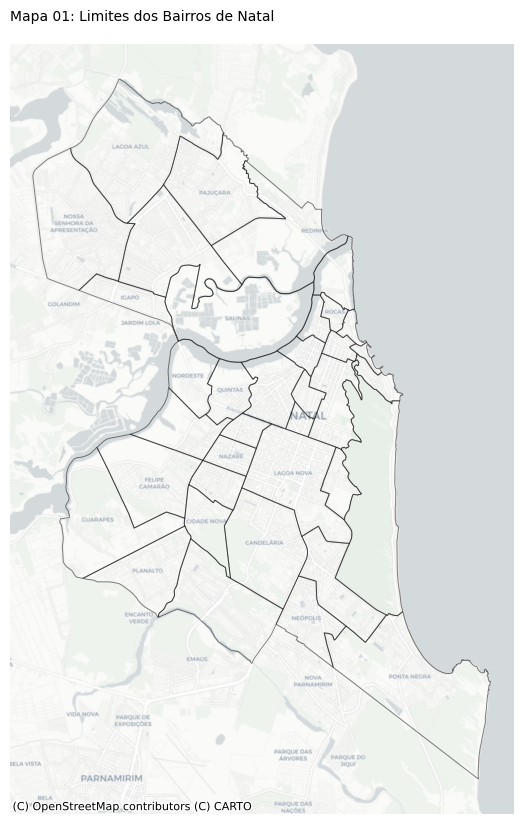

In [ ]:
# parametros do mapa
titulo_do_mapa = 'Mapa 01: Limites dos Bairros de Natal'
resolucao_dpi = 'figure'
tamanho_do_mapa = (10,10)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

# adicionando cartografia base
cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

plt.show()

##### **7.2. Qual a distribuição geográfica dos setores censitários em Natal?**

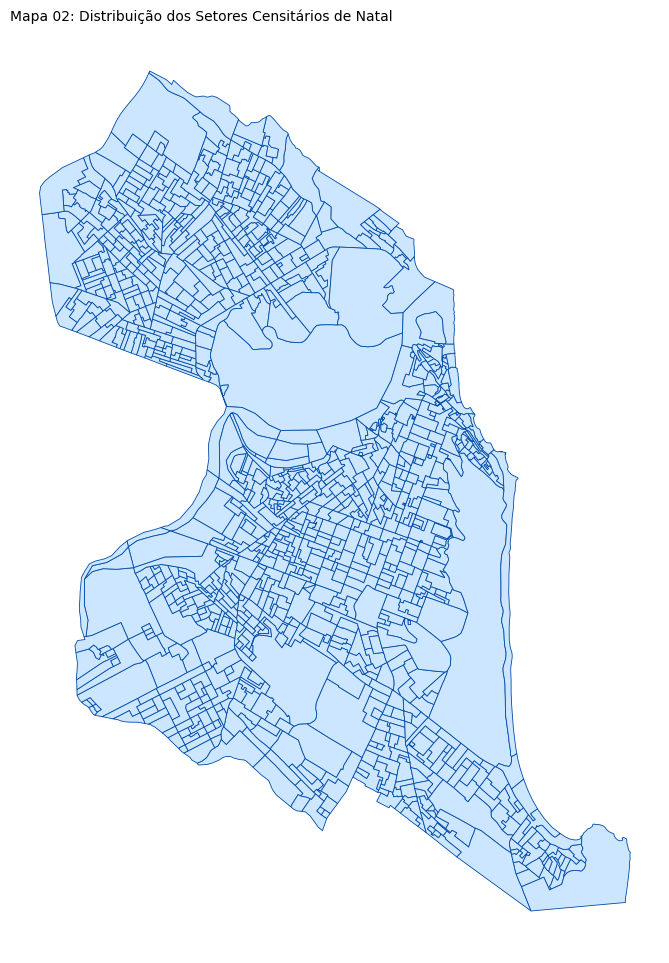

In [ ]:
titulo_do_mapa = 'Mapa 02: Distribuição dos Setores Censitários de Natal'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# malha de setores censitarios
gdf_setores_natal.plot(ax=ax,lw=.6, edgecolor='#004BA6', color='#CCE6FF')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

plt.show()

##### **7.3. Qual a distribuição geográfica da infraestrutura cicloviária em Natal?**

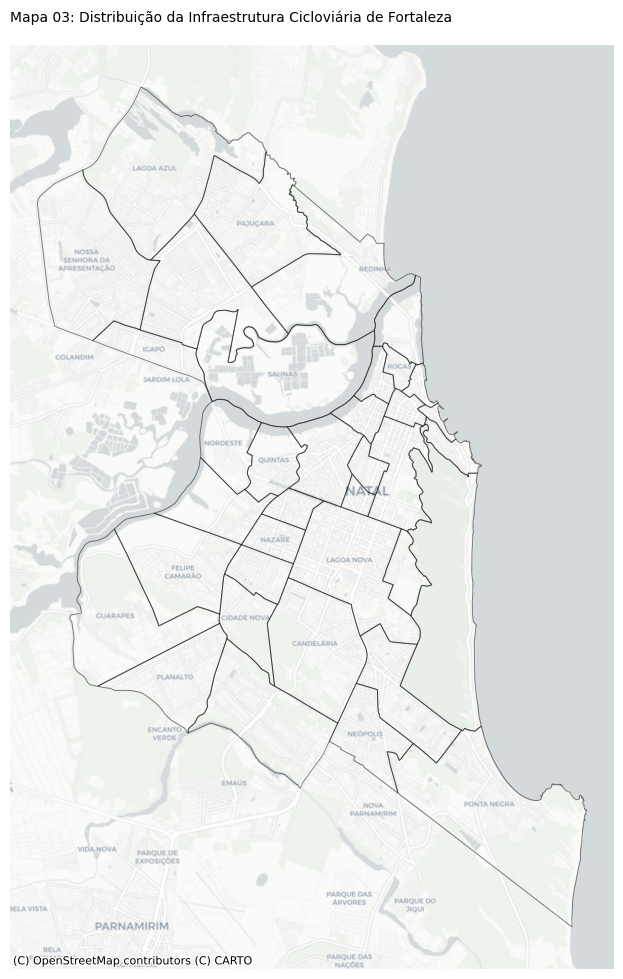

In [ ]:
titulo_do_mapa = 'Mapa 03: Distribuição da Infraestrutura Cicloviária de Fortaleza'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# adicionando camada de infraestrutura cicloviaria
gdf_

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

plt.show()

Natal conta atualmente com a seguinte infraestrutura:
- 72,72 km (município)
- 31,31 km (outros órgãos)

**Total:** 104,04 km

##### **7.4. Qual o percentual da população de Natal que habita a pelo menos 300m de infraestrutura cicloviária?**

######**7.4.1. Buffer de 300m da infraestrutura cicloviária**

In [ ]:
df_ciclovias = gdf_ciclovias[['Name','geometry']]
df_ciclofaixas = gdf_ciclofaixas[['Name','geometry']]
df_ciclorrotas = gdf_ciclorrotas[['Name','geometry']]
df_passeios = gdf_passeios[['Name','geometry']]

In [ ]:
# definindo sistema de coordenadas que represente a infraestrutura em um sistema cartesiano
projected_crs = "EPSG:3310"
projected_passeios = df_passeios.to_crs(projected_crs)
projected_ciclovias = df_ciclovias.to_crs(projected_crs)
projected_ciclofaixas = df_ciclofaixas.to_crs(projected_crs)
projected_ciclorrotas = df_ciclorrotas.to_crs(projected_crs)

# realizando buffer de 300m
ciclovias_buffer = projected_ciclovias.buffer(distance=300)
ciclofaixas_buffer = projected_ciclofaixas.buffer(distance=300)
ciclorrotas_buffer = projected_ciclorrotas.buffer(distance=300)
passeios_buffer = projected_passeios.buffer(distance=300)

# retornando ao sistema de coordenadas padrao
ciclovias_buffer = ciclovias_buffer.to_crs(gdf_bairros.crs)
ciclofaixas_buffer = ciclofaixas_buffer.to_crs(gdf_bairros.crs)
ciclorrotas_buffer = ciclorrotas_buffer.to_crs(gdf_bairros.crs)
passeios_buffer =  passeios_buffer.to_crs(gdf_bairros.crs)

Para mais informações sobre a transformação de um sistema de coordenadas geográficas para projetadas (sistema cartesiano), acesse este [link](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/geographic-vs-projected-coordinate-reference-systems-python/).

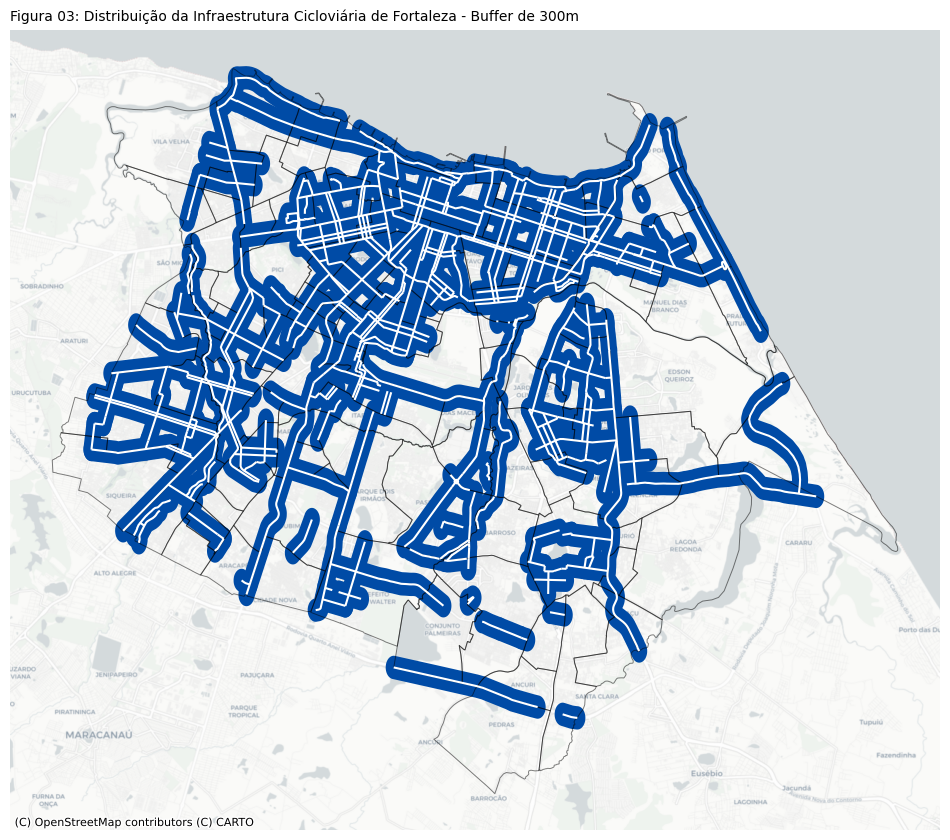

In [ ]:
titulo_do_mapa = 'Figura 03: Distribuição da Infraestrutura Cicloviária de Fortaleza - Buffer de 300m'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# malha de infraestrutura com buffer de 300m
passeios_buffer.plot(ax=ax, color='#004BA6')
ciclovias_buffer.plot(ax=ax, color='#004BA6')
ciclorrotas_buffer.plot(ax=ax, color='#004BA6')
ciclofaixas_buffer.plot(ax=ax, color='#004BA6')

# malha de infraestrutura
gdf_passeios.plot(ax=ax, color='white')
gdf_ciclovias.plot(ax=ax, color='white')
gdf_ciclofaixas.plot(ax=ax, color='white')
gdf_ciclorrotas.plot(ax=ax, color='white')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

plt.show()

**DataFrame resultante**

In [ ]:
gdfs = [ciclovias_buffer, ciclofaixas_buffer, ciclorrotas_buffer, passeios_buffer]
gdf_infraestrutura_buffered = pd.concat(gdfs, ignore_index=True)
gdf_infraestrutura_buffered

0      POLYGON ((-38.59427 -3.79270, -38.59408 -3.792...
1      POLYGON ((-38.48268 -3.72734, -38.48277 -3.725...
2      POLYGON ((-38.48063 -3.76217, -38.48063 -3.762...
3      POLYGON ((-38.49863 -3.76549, -38.49860 -3.765...
4      POLYGON ((-38.52319 -3.81896, -38.52319 -3.818...
                             ...                        
427    POLYGON ((-38.51102 -3.76553, -38.51085 -3.764...
428    POLYGON ((-38.50866 -3.76042, -38.50856 -3.760...
429    POLYGON ((-38.50769 -3.75845, -38.50754 -3.758...
430    POLYGON ((-38.51023 -3.76172, -38.51019 -3.761...
431    POLYGON ((-38.55919 -3.71943, -38.55918 -3.719...
Length: 432, dtype: geometry

###### **7.3.2. Interseção da infraestrutura com os setores**

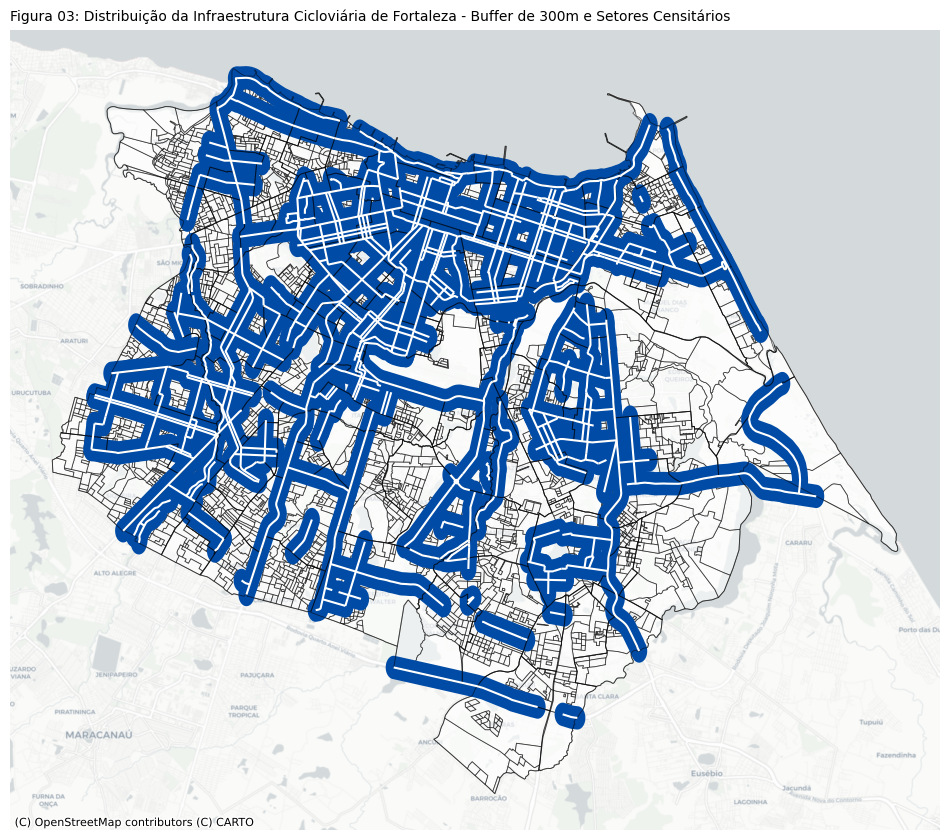

In [ ]:
titulo_do_mapa = 'Figura 03: Distribuição da Infraestrutura Cicloviária de Fortaleza - Buffer de 300m e Setores Censitários'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# malha de setores censitarios
gdf.plot(ax=ax,lw=.6, edgecolor='black', alpha=0.6, facecolor='white')

# malha de infraestrutura com buffer de 300m
passeios_buffer.plot(ax=ax, color='#004BA6')
ciclovias_buffer.plot(ax=ax, color='#004BA6')
ciclorrotas_buffer.plot(ax=ax, color='#004BA6')
ciclofaixas_buffer.plot(ax=ax, color='#004BA6')

# malha de infraestrutura
gdf_passeios.plot(ax=ax, color='white')
gdf_ciclovias.plot(ax=ax, color='white')
gdf_ciclofaixas.plot(ax=ax, color='white')
gdf_ciclorrotas.plot(ax=ax, color='white')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

plt.show()

União dos polígonos de infraestrutura cicloviária dilatados para não haver sobreposição de polígonos no cálculo do indicador

In [ ]:
# transformacao para DataFrame para substituir nome de coluna a posteriori
gdf_infraestrutura_buffered = gdf_infraestrutura_buffered.to_frame().reset_index()

# substituicao do nome da coluna
gdf_infraestrutura_buffered.rename(columns={0:'geometry'}, inplace=True)

# transformando para GeoDataframe
gdf_infraestrutura_buffered = gdf_infraestrutura_buffered.set_geometry('geometry')

# conversao da infraestrutura cicloviaria em um poligono unico
infra_union = gdf_infraestrutura_buffered.buffer(0).unary_union

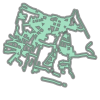

In [ ]:
infra_union

In [ ]:
# definindo sistema de referencia de coordenadas
gdf_infra_union = gpd.GeoDataFrame(geometry=[infra_union], crs='EPSG:4326')

In [ ]:
gdf_infra_union

geometry
0  MULTIPOLYGON (((-38.58848 -3.82081, -38.58841 ...

In [ ]:
# padronizando sistema de referência de coordenadas entre os gdfs
gdf_setores = gdf.to_crs('EPSG:4326')

# recortando areas dos setores censitarios em interseccao com a infraestrutura
setores_intersection = gdf_setores.overlay(gdf_infra_union, how='intersection')

In [ ]:
setores_intersection.head()

CD_SETOR  v0001                                           geometry
0  230440005130001P    866  POLYGON ((-38.51991 -3.71872, -38.51987 -3.718...
1  230440005130002P     35  POLYGON ((-38.51991 -3.71816, -38.51992 -3.718...
2  230440005130003P    125  POLYGON ((-38.52778 -3.72488, -38.52704 -3.725...
3  230440005130004P    266  MULTIPOLYGON (((-38.52104 -3.72158, -38.52105 ...
4  230440005130005P      4  POLYGON ((-38.53000 -3.72419, -38.53029 -3.725...

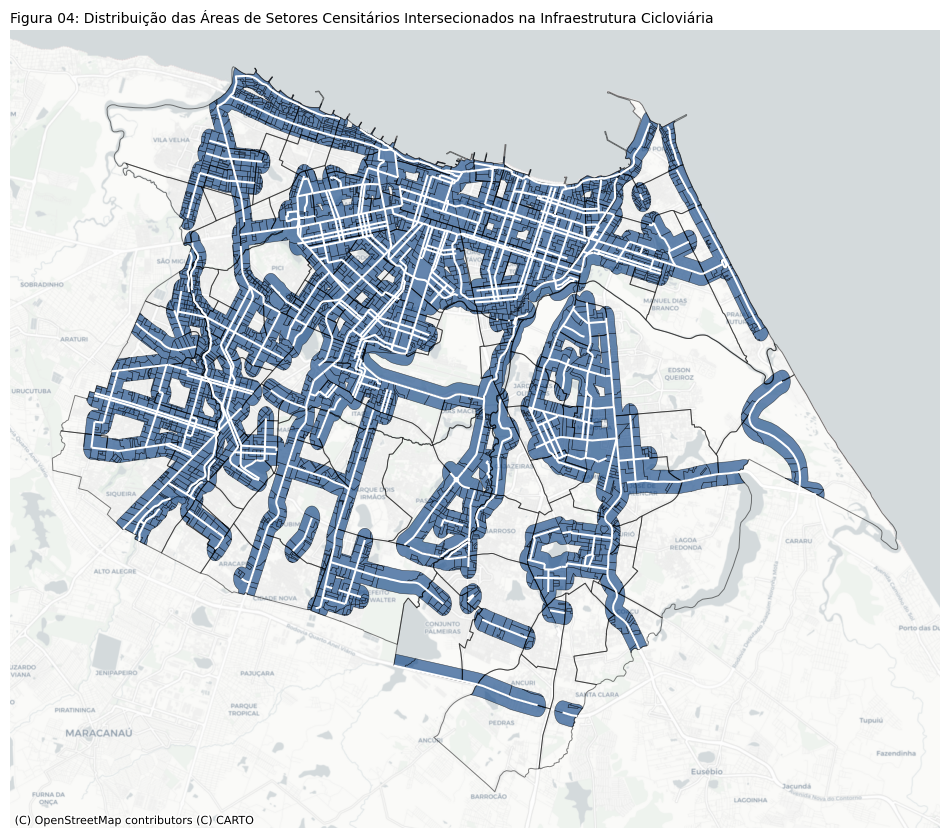

In [ ]:
titulo_do_mapa = 'Figura 04: Distribuição das Áreas de Setores Censitários Intersecionados na Infraestrutura Cicloviária'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# malha de setores intersecionados
setores_intersection.plot(ax=ax,lw=.4, edgecolor='black', alpha=0.6, facecolor='#00387d')

# malha de infraestrutura
gdf_passeios.plot(ax=ax, color='white')
gdf_ciclovias.plot(ax=ax, color='white')
gdf_ciclofaixas.plot(ax=ax, color='white')
gdf_ciclorrotas.plot(ax=ax, color='white')

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

# salvando no formato PNG
plt.savefig(fname='MapaInfraestruturaSetores.png',
            dpi=600,
            format='png',
            bbox_inches='tight')

plt.show()

###### **7.3.3. Cálculo do proporcional população por área de setor censitário intersecionado**

In [ ]:
# definindo sistema de coordenadas que represente os setores em um plano cartesiano
projected_crs = "EPSG:3310"
gdf_setores_completos = gdf.to_crs(projected_crs)
gdf_setores_intersecionados = setores_intersection.to_crs(projected_crs)

# adicionando area dos setores intersecionados
gdf_setores_intersecionados['area'] = gdf_setores_intersecionados.area

# adicionando area dos setores completos
gdf_setores_completos['area_setor'] = gdf_setores_completos.area

# junção dos DataFrames de setores completos e intersecionados
df_join = pd.merge(gdf_setores_completos,
                   gdf_setores_intersecionados,
                   on='CD_SETOR',
                   how='left')

# renomeando as colunas
df_join.rename(columns={
    'v0001_x':'NO_POPULACAO_TOTAL',
    'geometry_y':'GEOMETRY_COMPLETA',
    'geometry_x':'GEOMETRY_INTERSECAO',
    'area':'AREA_INTERSECAO',
    'area_setor':'AREA_COMPLETA'
}, inplace=True)

# removendo colunas desnecessarias
df_join.drop(columns='v0001_y', inplace=True)

# calculando dos proporcionais das areas que estao intersecionadas
df_join['PERCENTUAL_AREA'] = df_join['AREA_INTERSECAO']/df_join['AREA_COMPLETA']

# calculando populacao proporcional nas areas intersecionadas
df_join['POPULACAO_PROPORCIONAL'] = round(df_join['NO_POPULACAO_TOTAL'] * df_join['PERCENTUAL_AREA'], 0)

In [ ]:
df_join.head()

CD_SETOR  NO_POPULACAO_TOTAL  \
0  230440005130001P                 866   
1  230440005130002P                  35   
2  230440005130003P                 125   
3  230440005130004P                 266   
4  230440005130005P                   4   

                                 GEOMETRY_INTERSECAO  AREA_COMPLETA  \
0  POLYGON ((9589479.798 47241.956, 9589488.217 4...   44470.148835   
1  POLYGON ((9589427.011 47291.484, 9589449.607 4...  186814.849565   
2  POLYGON ((9589112.460 45980.197, 9589231.148 4...  316550.761691   
3  POLYGON ((9589553.244 46986.330, 9589589.577 4...  412277.138506   
4  POLYGON ((9589112.460 45980.197, 9588989.542 4...  118974.631957   

                                   GEOMETRY_COMPLETA  AREA_INTERSECAO  \
0  POLYGON ((9589488.217 47236.646, 9589499.546 4...     44470.148835   
1  POLYGON ((9589449.607 47270.273, 9589479.798 4...    170348.369218   
2  POLYGON ((9589231.148 46070.960, 9589311.216 4...    316550.761691   
3  MULTIPOLYGON (((9589589.577 46951.269, 9589638...    409879.993388   
4  POLYGON ((9588989.542 45887.624, 9589030.456 4...    118974.631957   

   PERCENTUAL_AREA  POPULACAO_PROPORCIONAL  
0         1.000000                   866.0  
1         0.911857                    32.0  
2         1.000000                   125.0  
3         0.994186                   264.0  
4         1.000000                     4.0

In [ ]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CD_SETOR                4422 non-null   object  
 1   NO_POPULACAO_TOTAL      4422 non-null   int64   
 2   GEOMETRY_INTERSECAO     4422 non-null   geometry
 3   AREA_COMPLETA           4422 non-null   float64 
 4   GEOMETRY_COMPLETA       3330 non-null   geometry
 5   AREA_INTERSECAO         3330 non-null   float64 
 6   PERCENTUAL_AREA         3330 non-null   float64 
 7   POPULACAO_PROPORCIONAL  3330 non-null   float64 
dtypes: float64(4), geometry(2), int64(1), object(1)
memory usage: 276.5+ KB


A escolha do **Left Join** foi feita para garantir que, mesmo que não haja setores censitários que se sobreponham à infraestrutura cicloviária, eles ainda apareçam no dataframe resultante.

In [ ]:
# selecao das colunas necessarias para o calculo do indicador
df_join.drop(columns=['GEOMETRY_COMPLETA'], inplace=True)

# preencheando NaN com zero
df_join.fillna(0, inplace=True)

###### **7.3.4. People Near Bike Lanes (PNB)**

Total da população de Fortaleza que está a pelo menos 300m de infraestrutura cicloviária

In [ ]:
PNB = sum(df_join['POPULACAO_PROPORCIONAL'])/populacao_fortaleza

print(f'People Near Bike Lanes - {round(PNB*100,1)}% da população de Fortaleza, vive a pelo menos 300m de infraestrutura cicloviária')

People Near Bike Lanes - 61.6% da população de Fortaleza, vive a pelo menos 300m de infraestrutura cicloviária


##### **7.4. Qual o percentual da população por bairro que habita a pelo menos 300m de infraestrutura cicloviária em Fortaleza?**

In [ ]:
# criando coluna de ponto representativo para
gdf['representative_point'] = gdf.representative_point()

# criando GeoDataFrame a partir da geometria dos pontos representativos
gdf_points = gpd.GeoDataFrame(gdf, geometry='representative_point')

# conversao de sistema de referencia de coordenadas
gdf_points = gdf_points.to_crs(gdf_bairros.crs)

In [ ]:
gdf_points.head()

CD_SETOR  v0001                                           geometry  \
0  230440005130001P    866  POLYGON ((-38.51992 -3.71861, -38.51991 -3.718...   
1  230440005130002P     35  POLYGON ((-38.51990 -3.71783, -38.51991 -3.718...   
2  230440005130003P    125  POLYGON ((-38.52888 -3.72454, -38.52778 -3.724...   
3  230440005130004P    266  POLYGON ((-38.52102 -3.72103, -38.52104 -3.721...   
4  230440005130005P      4  POLYGON ((-38.52888 -3.72454, -38.53000 -3.724...   

         representative_point  
0  POINT (-38.52104 -3.71945)  
1  POINT (-38.52245 -3.71841)  
2  POINT (-38.52847 -3.72743)  
3  POINT (-38.52511 -3.72403)  
4  POINT (-38.53091 -3.72529)

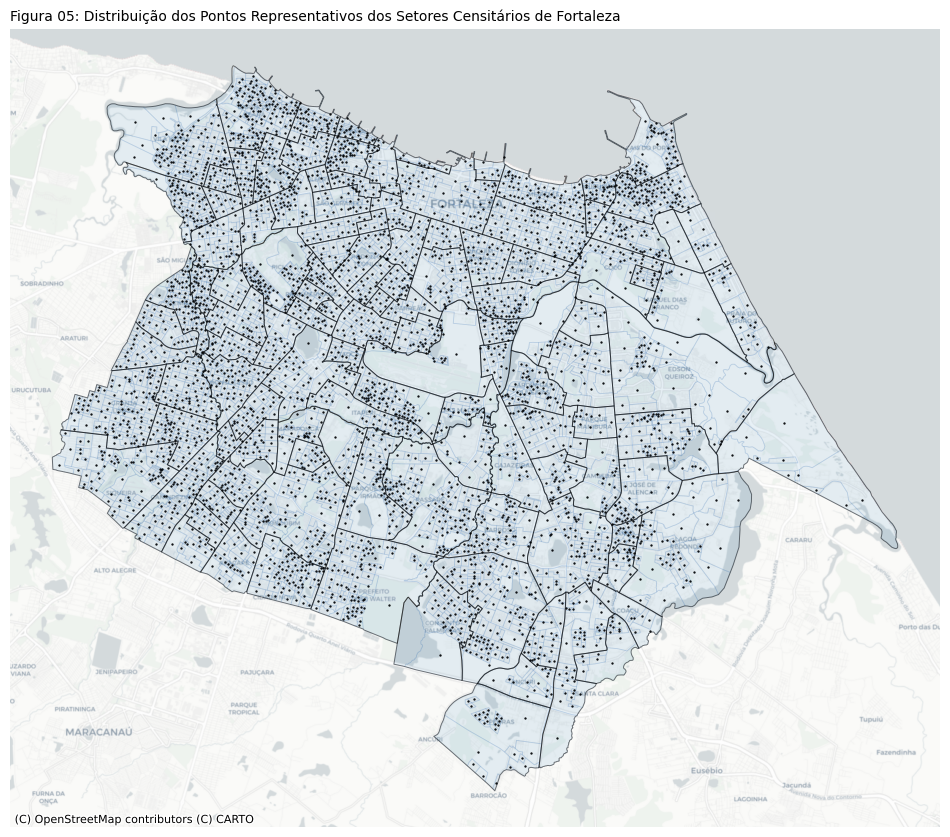

In [ ]:
titulo_do_mapa = 'Figura 05: Distribuição dos Pontos Representativos dos Setores Censitários de Fortaleza'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)

# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='black', linewidth=.7, alpha=.5)

# criando geodataframe a partir de df
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# malha de setores censitarios
gdf.plot(ax=ax,lw=.6, edgecolor='#004BA6', alpha=0.1)

# malha de setores censitarios
gdf_points.plot(ax=ax, color='black', facecolor='#00387d', markersize=0.4)

# configurando nome
plt.title(titulo_do_mapa, loc='left', fontsize=10)

# removendo eixos da visualizacao
plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

plt.show()

###### **7.4.1. Adicionando bairros aos setores censitários**

In [ ]:
# filtrando informacoes necessarias de gdf_bairros
gdf_bairros_geometria = gdf_bairros[['id','Nome','geometry']]

# padronizando sistema de referencia de coordenadas
gdf_points = gdf_points.to_crs(gdf_bairros_geometria.crs)

# implementando spatial join para adicionar geometria de bairros
gdf_setores_bairros = gdf_points.sjoin(gdf_bairros_geometria,how='left')

# renomeando GeoDataFrame
gdf_setores_bairros.rename(columns={'v0001':'populacao_setor',
                                    'representative_point':'representative_point_setor',
                                    'Nome':'bairro'}, inplace=True)

# removendo colunas desnecessarias
gdf_setores_bairros.drop(columns=['index_right','id'], inplace=True)

# adicionando coluna de bairros no dataframe de intersecao a partir dos setores completos
df_intersection_bairros = df_join.merge(gdf_setores_bairros[['CD_SETOR','bairro']], how='left')

# renomeando coluna do dataframe de intersecao
df_intersection_bairros.rename(columns={'bairro':'BAIRRO'}, inplace=True)

In [ ]:
df_intersection_bairros.head(2)

CD_SETOR  NO_POPULACAO_TOTAL  \
0  230440005130001P                 866   
1  230440005130002P                  35   

                                 GEOMETRY_INTERSECAO  AREA_COMPLETA  \
0  POLYGON ((9589479.798 47241.956, 9589488.217 4...   44470.148835   
1  POLYGON ((9589427.011 47291.484, 9589449.607 4...  186814.849565   

   AREA_INTERSECAO  PERCENTUAL_AREA  POPULACAO_PROPORCIONAL  BAIRRO  
0     44470.148835         1.000000                   866.0  Centro  
1    170348.369218         0.911857                    32.0  Centro

In [ ]:
df_intersection_bairros.groupby(by='BAIRRO').sum(numeric_only=True).NO_POPULACAO_TOTAL

BAIRRO
Aerolândia          9368
Aeroporto           8995
Aldeota            42580
Alto da Balança    10407
Amadeu Furtado      9681
                   ...  
Vicente Pinzón     46151
Vila Peri          17550
Vila União         13275
Vila Velha         52881
Álvaro Weyne       21809
Name: NO_POPULACAO_TOTAL, Length: 121, dtype: int64

In [ ]:
# agrupamento por bairro dos setores censitários intersecionados
df_group_intersection = df_intersection_bairros.groupby(by='BAIRRO').sum(numeric_only=True)

# adequacao do dataframe de agrupamento
df_group_intersection.reset_index(inplace=True)
df_group_intersection.drop('PERCENTUAL_AREA', axis=1, inplace=True)
df_group_intersection.head()

BAIRRO  NO_POPULACAO_TOTAL  AREA_COMPLETA  AREA_INTERSECAO  \
0       Aerolândia                9368   1.084797e+06     7.120758e+05   
1        Aeroporto                8995   6.225574e+06     2.146011e+06   
2          Aldeota               42580   3.881267e+06     3.754355e+06   
3  Alto da Balança               10407   8.991094e+05     4.642287e+05   
4   Amadeu Furtado                9681   9.359412e+05     9.357900e+05   

   POPULACAO_PROPORCIONAL  
0                  7116.0  
1                  2853.0  
2                 41339.0  
3                  5904.0  
4                  9679.0

###### **7.4.2. Cálculo do PNB por bairro de Fortaleza**

In [ ]:
# calculo do PNB. por bairro
df_group_intersection['PNB'] = df_group_intersection['POPULACAO_PROPORCIONAL']/df_group_intersection['NO_POPULACAO_TOTAL']

# salvando em um arquivo CSV
df_group_intersection.sort_values(by='PNB', ascending=False).to_csv('202404_PNB_Bairro_Fortaleza.csv', index=False, encoding='utf-8')

# adicionando geometria dos bairros para visualizacao do mapa coropletico
geometria_bairros = gdf_bairros[['Nome','geometry']].rename(columns={'Nome':'BAIRRO'})
df_group_intersection = df_group_intersection.merge(geometria_bairros, on='BAIRRO', how='left')
gdf_group_intersection = gpd.GeoDataFrame(df_group_intersection, geometry='geometry')

In [ ]:
gdf_group_intersection.head()

BAIRRO  NO_POPULACAO_TOTAL  AREA_COMPLETA  AREA_INTERSECAO  \
0       Aerolândia                9368   1.084797e+06     7.120758e+05   
1        Aeroporto                8995   6.225574e+06     2.146011e+06   
2          Aldeota               42580   3.881267e+06     3.754355e+06   
3  Alto da Balança               10407   8.991094e+05     4.642287e+05   
4   Amadeu Furtado                9681   9.359412e+05     9.357900e+05   

   POPULACAO_PROPORCIONAL       PNB  \
0                  7116.0  0.759607   
1                  2853.0  0.317176   
2                 41339.0  0.970855   
3                  5904.0  0.567310   
4                  9679.0  0.999793   

                                            geometry  
0  MULTIPOLYGON (((-38.51707 -3.76988, -38.51704 ...  
1  MULTIPOLYGON (((-38.55038 -3.77092, -38.55038 ...  
2  MULTIPOLYGON (((-38.50885 -3.74165, -38.50980 ...  
3  MULTIPOLYGON (((-38.51707 -3.76988, -38.51719 ...  
4  MULTIPOLYGON (((-38.55945 -3.75051, -38.55985 ...

###### **7.4.3. Mapa Coroplético da Distribuição do Indicador PNB por Bairro**

In [ ]:
quantis=10
titulo_do_mapa = 'Figura 06: Distribuição do Percentual de Pessoas que Vivem Até 300m de Infraestrutura Cicloviária em Fortaleza'
resolucao_dpi = 'figure'
tamanho_do_mapa = (12,12)
colors = ['#CCE6FF', '#A0CAFF', '#75AEFF', '#4A92FF', '#1E77FF', '#005BC9', '#004BA6', '#00387D', '#002654', '#00132B']
paleta_coropletico = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
missing = {'color':'darkgrey',
            'edgecolor':'grey',
            'label':'Sem informações'}


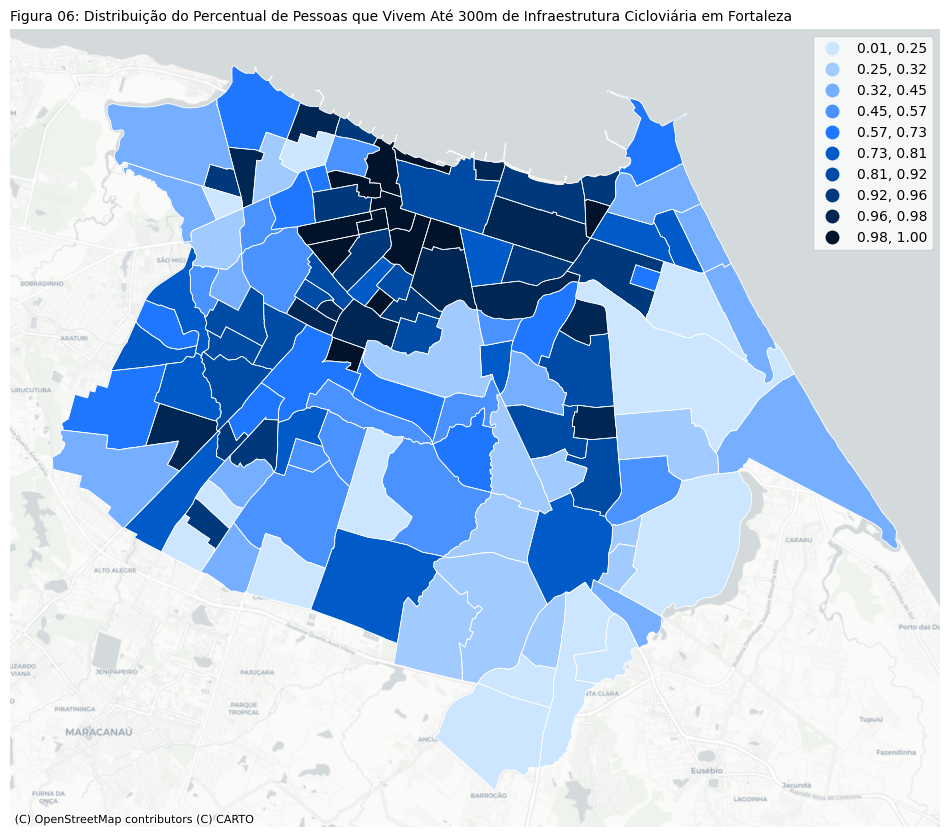

In [ ]:
# criando figura base
fig, ax = plt.subplots(figsize=tamanho_do_mapa)

# criando camada de limites dos bairros
gdf_bairros.boundary.plot(ax=ax, color='white', linewidth=.2, alpha=.8)

# camada do mapa coropletico
gdf_group_intersection.plot(ax = ax,
                            scheme = 'quantiles',
                            column = 'PNB',
                            k = quantis,
                            lw = .6,
                            edgecolor='white',
                            cmap = paleta_coropletico,
                            legend = True)

plt.title(titulo_do_mapa, loc='left', fontsize=10)

plt.axis('off')

cx.add_basemap(ax=ax, crs=gdf_bairros.crs, zoom=13, source='CartoDB positron')

# salvando no formato PNG
plt.savefig(fname='MapaCoropleticoPNB.png',
            dpi=600,
            format='png',
            bbox_inches='tight')

plt.show()

###### **7.4.4. Histograma do PNB nos bairros de Fortaleza**

In [ ]:
# metadados do histograma do indicador PNB
df = gdf_group_intersection
indicator = 'PNB'
bins=11
min = df[indicator].min()
max = df[indicator].max()

# histograma
histogram = np.histogram(df[indicator], range=(min,max), bins=bins)

# dataframe contendo os intervalos e contagem de bairros
df_histogram = pd.DataFrame()
df_histogram['limiar'] = histogram[1][1:]
df_histogram['count_bairros'] = histogram[0]
df_histogram['limiar'] = round(df_histogram['limiar'],2)

In [ ]:
df_histogram

limiar  count_bairros
0     0.10              5
1     0.19              4
2     0.28              8
3     0.37             11
4     0.46             10
5     0.55             10
6     0.64              3
7     0.73             11
8     0.82             11
9     0.91             11
10    1.00             37

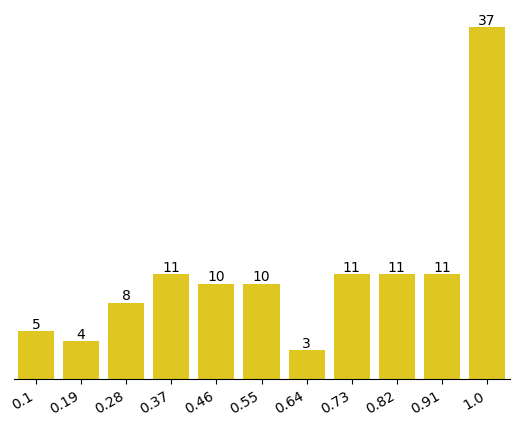

In [ ]:
ax = sns.barplot(data=df_histogram,
                 x='limiar',
                 y='count_bairros',
                 color='#ffdd00')

ax.bar_label(ax.containers[0], fontsize=10);

# removendo linhas de eixos
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_visible(False)

# removendo label do eixo x
ax.set_xlabel('')

ax.set_xticks(np.arange(len(df_histogram['limiar'])))
ax.set_xticklabels(df_histogram['limiar'], rotation=30, ha='right')

plt.show()

In [ ]:
df_histogram.to_csv('202404_HistogramaProximidadeCiclo.csv',
                    encoding='utf-8',
                    index=False)

###### **7.4.5. Cálculo da assimetria, média e mediana**

* O cálculo da assimetria da distribuição leva em consideração o coeficiente de assimetria entre os percentis 10 e 90 multiplicado por 100:

$$
A_P = (-1)*\frac{ P_{90} - 2M_d + P_{10} }{ P_{90} - P_{10} } × 100
$$

Onde:

$P_{10} =$ 10º percentil da amostra

$P_{90} =$ 90º percentil da amostra

$M_d =$ 50º percentil da amostra (valor mediano)


 * O coeficiente de assimetria entre os percentis 10 e 90 multiplicado por 100 assume valores na faixa:  $ -100 \le A_p \le +100 $

 * A interpretação do valor é:

\begin{cases}
    Se\ A_{p} > 0 & \text{Valores concentrados na direita da distribuição}\\
    Se\ A_{p} = 0 & \text{Valores concentrados no centro da distribuição}\\
    Se\ A_{p} < 0 & \text{Valores concentrados na esquerda da distribuição}\\
\end{cases}

* O valor absoluto do coeficiente indica a intensidade da assimetria.

In [ ]:
# função que retorna o coeficiente quartil de assimetria
def coeficiente_quartil_assimetria(a:'pd.core.series.Series'):
    p10 = a.quantile(.1)
    md = a.quantile(.5)
    p90 = a.quantile(.9)
    skew = (-1)*((p90 + p10 - (2*md)) / (p90 - p10)) * 100

    return skew

In [ ]:
coeficiente_quartil_assimetria(df['PNB'])

30.02800780395591

In [ ]:
mediana = df['PNB'].median()
mediana

0.7263140817650876

In [ ]:
media = df['PNB'].mean()
media

0.6526274134338678

##### **7.5. Como foi o histórico de implementação da infraestrutura cicloviária ao longo do tempo?**  

###### **7.5.1. Adequação dos dados das infraestruturas**

A adequação dos dados é composta pelas seguintes etapas:
- Substituição do nome da coluna `Data_de_implanta____o` para `data_implantacao` e `Name` para `nome`;
- Converte o tipo da variável `data_implantacao` para *datetime;*
- Preenchimento de linhas vazia com `NaN`;
- Preenchimento dos valores ausentes com o ano da linha anterior.

In [ ]:
def processa_infraestrutura(gdf: gpd.GeoDataFrame(), tipo:str) -> gpd.GeoDataFrame():
    ''' Funcao que realiza os procedimentos descritos na célula acima
        Args:
            gdf: GeoDataFrame com os dados da infraestrutura
            tipo: Tipologia da infraestrutura (ciclovia,ciclofaixa,ciclorrota ou passeio compartilhado)
        Returns:
            gdf_processed: GeoDataFrame com os dados processados
    '''

    # selecao das colunas necessarias e correcao do nome da coluna
    gdf_filtered = gdf[['Name','Data_de_implanta____o','Extens__o__km_','geometry']]
    gdf_processed = gdf_filtered.rename(columns={
    'Name':'nome',
    'Data_de_implanta____o':'data_implantacao',
    'Extens__o__km_':'extensao_km'})

    # corrigindo linhas especificas de gdf_ciclovias
    gdf_processed.data_implantacao = gdf_processed.data_implantacao.apply(lambda x : x.replace(' (alterado em 05/09/2023)',''))
    gdf_processed.extensao_km = gdf_processed.extensao_km.apply(lambda x : x.replace(',','.'))
    gdf_processed.extensao_km = gdf_processed.extensao_km.apply(lambda x : x.replace('km',''))
    gdf_processed.extensao_km = gdf_processed.extensao_km.apply(lambda x : x.replace(' km',''))

    # preenchendo com NaN
    gdf_processed = gdf_processed.apply(lambda x: x.replace('',np.nan))
    gdf_processed = gdf_processed.apply(lambda x: x.replace('-',np.nan))

    # transformacao do tipo da variavel data_implantacao
    gdf_processed['data_implantacao'] = pd.to_datetime(gdf_processed['data_implantacao'], format='%d/%m/%Y')

    # transformacao do tipo da variavel extensao_km
    gdf_processed['extensao_km'] = gdf_processed['extensao_km'].astype(float)

    # adicionando coluna do ano
    gdf_processed['ano'] = gdf_processed['data_implantacao'].dt.year

    # preenchimento dos valores nulos de ano com o valor da linha anterior
    gdf_processed['ano'] = gdf_processed['ano'].fillna(method='ffill')

    gdf_crs_original = gdf_processed.crs

    # projected coordinate system
    gdf_processed = gdf_processed.to_crs(32619)

    # preenchendo NaN em extensao_km por seu valor calculado atraves do metodo length
    gdf_processed['extensao_km'] = gdf_processed['extensao_km'].fillna(round((gdf_processed['geometry'].length / 1000),1))

    # retornando para o sistema de coordenadas anterior
    gdf_processed = gdf_processed.to_crs(gdf_crs_original)

    # adicionando coluna 'tipo'
    gdf_processed['tipo'] = tipo

    return gdf_processed

**Resultados:**

In [ ]:
gdf_ciclovias_processed = processa_infraestrutura(gdf_ciclovias, 'Ciclovia')
gdf_ciclorrotas_processed = processa_infraestrutura(gdf_ciclorrotas, 'Ciclorrota')
gdf_ciclofaixas_processed = processa_infraestrutura(gdf_ciclofaixas, 'Ciclofaixa')
gdf_passeios_processed = processa_infraestrutura(gdf_passeios, 'Passeio Compartilhado')

In [ ]:
gdf_infraestruturas = pd.concat([gdf_ciclofaixas_processed,
                                 gdf_ciclovias_processed,
                                 gdf_ciclorrotas_processed,
                                 gdf_passeios_processed])

In [ ]:
gdf_infraestruturas.head()

nome data_implantacao  extensao_km  \
0                          Av. Benjamim Brasil       2012-09-01          2.1   
1                         Rua Canuto de Aguiar       2013-10-01          2.2   
2                     Rua Ana Bilhar (parte 1)       2013-09-01          1.9   
3  Av. Santos Dumont (trecho antes do binário)       2014-09-01          1.7   
4                                 Av. Dom Luís       2014-06-01          1.4   

                                            geometry     ano        tipo  
0  LINESTRING Z (-38.55484 -3.81003 0.00000, -38....  2012.0  Ciclofaixa  
1  LINESTRING Z (-38.50230 -3.72841 0.00000, -38....  2013.0  Ciclofaixa  
2  LINESTRING Z (-38.48500 -3.73145 0.00000, -38....  2013.0  Ciclofaixa  
3  LINESTRING Z (-38.51686 -3.73019 0.00000, -38....  2014.0  Ciclofaixa  
4  LINESTRING Z (-38.48911 -3.73597 0.00000, -38....  2014.0  Ciclofaixa

In [ ]:
gdf_infraestruturas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 432 entries, 0 to 8
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   nome              432 non-null    object        
 1   data_implantacao  420 non-null    datetime64[ns]
 2   extensao_km       432 non-null    float64       
 3   geometry          432 non-null    geometry      
 4   ano               432 non-null    float64       
 5   tipo              432 non-null    object        
dtypes: datetime64[ns](1), float64(2), geometry(1), object(2)
memory usage: 23.6+ KB


In [ ]:
# construindo dataframe com a serie historica de implementacao das infraestruturas
df_serie_infra = gdf_infraestruturas.groupby(by=['ano','tipo']).sum(numeric_only=True).reset_index()
df_serie_infra.tipo = df_serie_infra.tipo.astype('category')

# adicionando todas infraestruturas nos anos que nao foram implementadas e preenchendo extensao com 0km
anos = np.arange(2000,2025,1)
tipos = ['Ciclovia', 'Ciclofaixa', 'Ciclorrota', 'Passeio Compartilhado']

for ano in anos:
  for tipo in tipos:
    if not ((df_serie_infra['ano'] == ano) & (df_serie_infra['tipo'] == tipo)).any():
        df_serie_infra = pd.concat([df_serie_infra, pd.DataFrame({'ano': [ano], 'tipo': [tipo], 'extensao_km': [0]})], ignore_index=True)

# convertendo ano para o tipo datetime
df_serie_infra['ano'] = pd.to_datetime(df_serie_infra['ano'], format='%Y')
df_serie_infra['ano'] = df_serie_infra['ano'].dt.year

# ordenando por ano
df_serie_infra = df_serie_infra.sort_values(by=['ano','tipo'])

**Resultado:**

In [ ]:
df_serie_infra

ano                   tipo  extensao_km
41  2000             Ciclofaixa          0.0
42  2000             Ciclorrota          0.0
0   2000               Ciclovia         29.0
43  2000  Passeio Compartilhado          0.0
45  2001             Ciclofaixa          0.0
..   ...                    ...          ...
96  2023  Passeio Compartilhado          0.0
40  2024             Ciclofaixa          3.3
98  2024             Ciclorrota          0.0
97  2024               Ciclovia          0.0
99  2024  Passeio Compartilhado          0.0

[100 rows x 3 columns]

In [ ]:
fig = px.bar(df_serie_infra,
            title='Histórico da Implementação de Infraestrutura Cicloviária',
             x='ano',
             y='extensao_km',
             color='tipo',
             template='plotly_white',
             labels=dict(ano='Ano', extensao_km="Extensão (km)", tipo="Infraestrutura"))

fig.update_xaxes(categoryorder='array', categoryarray=np.arange(2000,2025,1), type='category')

fig.update_layout(bargap=0.45)

fig.show()

In [ ]:
# realizando soma cumulativa por ano e por tipo em df_serie_infra
df_serie_infra['extensao_km_cumulativa'] = df_serie_infra.groupby('tipo')['extensao_km'].cumsum()

# total por ano, independente da infraestrutura
df_serie_infra['total_extensao_km_cumulativa'] = df_serie_infra.groupby('ano')['extensao_km_cumulativa'].transform('sum')

In [ ]:
fig = px.line(df_serie_infra,
            title='Implementação de Infraestrutura Cicloviária por Tipologia',
             x='ano',
             y='extensao_km_cumulativa',
             color='tipo',
             template='plotly_white',
             labels=dict(ano='Ano', extensao_km_cumulativa="Extensão (km)", tipo="Infraestrutura"))

fig.update_xaxes(categoryorder='array', categoryarray=np.arange(2000,2025,1), type='category')

fig.show()


In [ ]:
fig = px.area(df_serie_infra,
            title='Total de Infraestrutura Cicloviária por Ano',
             x='ano',
             y='total_extensao_km_cumulativa',
             template='plotly_white',
             labels=dict(ano='Ano', total_extensao_km_cumulativa="Extensão (km)"))

fig.update_xaxes(categoryorder='array', categoryarray=np.arange(2000,2025,1), type='category')

fig.update_traces(line_color='black', line_width=3)

fig.show()

**Exportando dados:**

In [ ]:
df_serie_infra.to_csv('202404_HistoricoInfraestrutura.csv', index=False, encoding='utf-8')

In [ ]:
gdf_infraestruturas.to_file('202404_InfraestruturaCicloviaria.geojson', driver='GeoJSON')